In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex
from tqdm.notebook import tqdm

import sklearn as sk
import seaborn as sns

import torch
from torch.utils.data import TensorDataset

from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.model_selection import ParameterGrid

# Получаем dataset
from ucimlrepo import fetch_ucirepo   
servo = fetch_ucirepo(id=87) 

## Выборка: [*Servo Data Set*](https://archive.ics.uci.edu/ml/datasets/Servo)

Данные состоят из экспериментальных измерений времени перехода (rise time) _target_ некоторого сервопривода на изменение требуемого положения. Эксперименты проведены для нескольких типов моторчика и винтов.

_Сопровождающее описание подсказывает, что поведение будет сильно нелинейным._

В качестве признаков выступают:
- _motor_ -- тип моторчика (категориальный),
- _screw_ -- тип винта (категориальный),
- _pgain_ (proportional gain) -- коэффициент пропорциональности между отклонением от требуемого положения _e(t)_ и амплитудой контрольного сигнала (вещественный),
- _vgain_ (velocity gain) -- коэффициент пропорциональности между производной _de/dt_ и амплитудой контрольного сигнала (вещественный).

![Scheme](scheme.png)

In [3]:
df = servo.data.features 
targets = servo.data.targets

# Вносим все данные в единый dataframe.
df['target'] = targets['class']
features = ['motor', 'screw', 'pgain', 'vgain']
target = 'target'

display(Markdown(f'Размер выборки $l={len(df)}$.'))
display(df.sample(5, random_state = 0))


Размер выборки $l=167$.

,motor,screw,pgain,vgain,target
150,B,A,5,4,0.806255
56,A,A,4,2,0.881255
123,C,E,3,1,1.299997
60,E,B,4,2,0.581253
100,B,C,4,2,0.506252


### Категориальные признаки

Так как _motor_ и _screw_ -- категориальные признаки, конвертируем их в численные.
Для того, чтобы их значение имело какой-то статистический смысл конвертируем
их в среднее значение _target_ для каждого признака.

In [4]:
motors = np.unique(df['motor'])
screws = np.unique(df['screw'])

m_vals = {}
s_vals = {}
for m in motors:
    m_vals[m] = np.mean(df.loc[df['motor'] == m]['target'])

for s in screws:
    s_vals[s] = np.mean(df.loc[df['screw'] == s]['target'])
    
display(m_vals, s_vals)

{'A': np.float64(1.7611106688888891),
 'B': np.float64(1.681942367777778),
 'C': np.float64(1.2540610067500002),
 'D': np.float64(0.9176125145454546),
 'E': np.float64(1.144893208181818)}

{'A': np.float64(1.768461212142857),
 'B': np.float64(1.3919625091428571),
 'C': np.float64(1.2485862280645161),
 'D': np.float64(1.1612471173333332),
 'E': np.float64(1.2256432917241378)}

In [5]:
dffix = df.copy()
display(dffix.sample(5, random_state = 0))
dffix['motor'] = dffix['motor'].apply(lambda x: m_vals[x])
dffix['screw'] = dffix['screw'].apply(lambda x: s_vals[x])
display(dffix.sample(5, random_state = 0))

,motor,screw,pgain,vgain,target
150,B,A,5,4,0.806255
56,A,A,4,2,0.881255
123,C,E,3,1,1.299997
60,E,B,4,2,0.581253
100,B,C,4,2,0.506252


,motor,screw,pgain,vgain,target
150,1.681942,1.768461,5,4,0.806255
56,1.761111,1.768461,4,2,0.881255
123,1.254061,1.225643,3,1,1.299997
60,1.144893,1.391963,4,2,0.581253
100,1.681942,1.248586,4,2,0.506252


### Добавление признаков

Поскольку _pgain_ и _vgain_ задают отношение между ошибкой и мгновенной мощностью/крутящим моментом сервопривода, то время может зависеть от их экспоненты. Добавим их в признаки.  

In [6]:
dffix['pgain_exp'] = np.exp(-dffix['pgain'])
dffix['vgain_exp'] = np.exp(-dffix['vgain'])
features.append('pgain_exp')
features.append('vgain_exp')
display(dffix.sample(5, random_state = 0))

,motor,screw,pgain,vgain,target,pgain_exp,vgain_exp
150,1.681942,1.768461,5,4,0.806255,0.006738,0.018316
56,1.761111,1.768461,4,2,0.881255,0.018316,0.135335
123,1.254061,1.225643,3,1,1.299997,0.049787,0.367879
60,1.144893,1.391963,4,2,0.581253,0.018316,0.135335
100,1.681942,1.248586,4,2,0.506252,0.018316,0.135335


## Визуализация выборки

In [7]:
# Init matrix for heatmap graphs
Pgain = np.unique(df['pgain'])
Vgain = np.unique(df['vgain'])
print(f"{Pgain=}, {Vgain=}")
arr = np.full((len(Vgain), len(Pgain)), np.nan)
Heatmap = pd.DataFrame(arr)
Heatmap.columns = Pgain
Heatmap.set_index(Vgain, inplace=True)

def customHeatmap(pgain, vgain, target, vmin, vmax, **kwargs):
    hm = Heatmap.copy()

    pgain = list(pgain)
    vgain = list(vgain)
    target = list(target)
    for p, v, t in zip(pgain, vgain, target):
        hm.loc[v, p] = t

    ax = sns.heatmap(hm, annot=True,
                     center=0, cbar=False, vmin=vmin, vmax=vmax,
                     cmap=sns.color_palette("vlag", as_cmap=True))
    ax.invert_yaxis()

def dataframeHeatmap( df):
    order = ['A', 'B', 'C', 'D', 'E']
    g = sns.FacetGrid(df, row="motor", col="screw", margin_titles=True, col_order=order, row_order=order)
    g.map(customHeatmap, "pgain", "vgain", "target", vmin=np.min(df[target]), vmax=np.max(df[target]))


Pgain=array([3, 4, 5, 6]), Vgain=array([1, 2, 3, 4, 5])


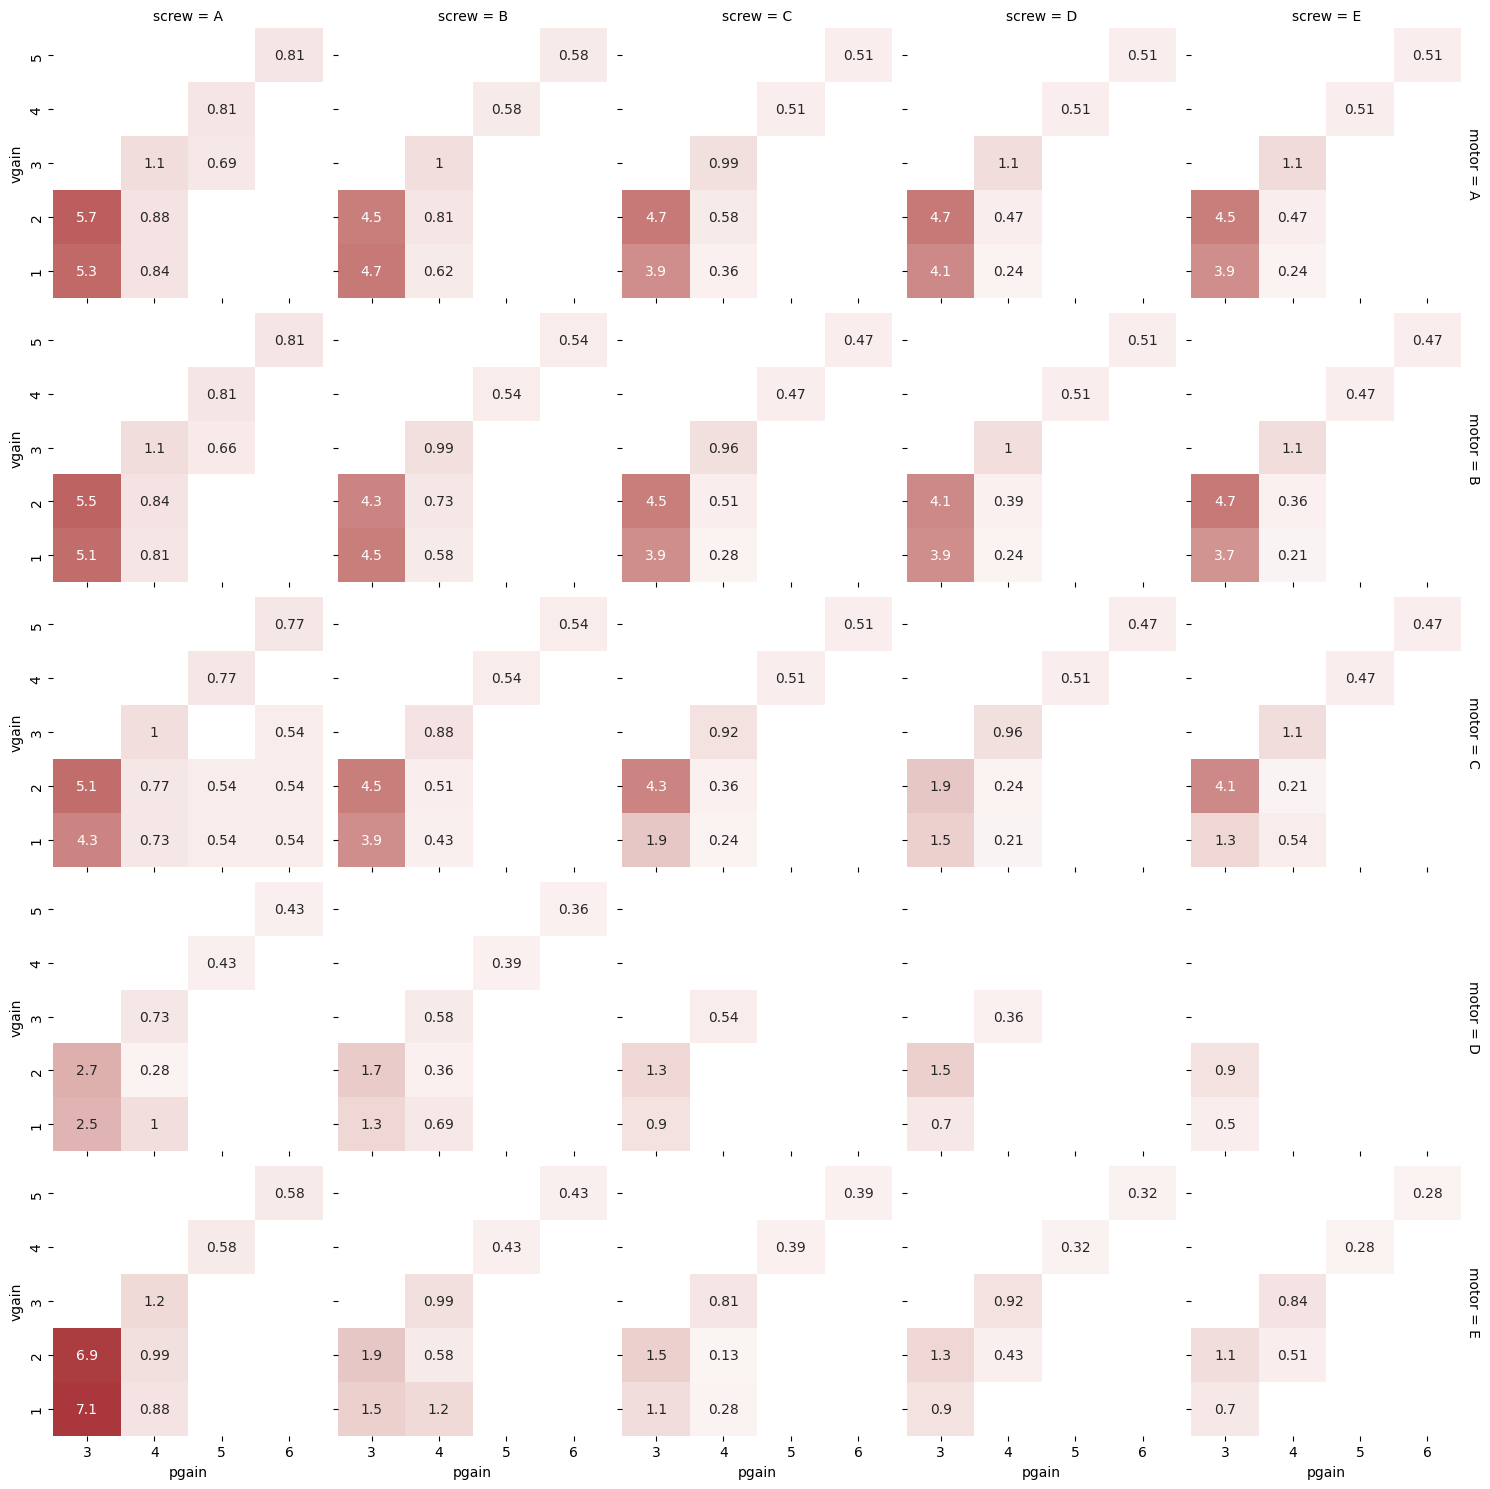

In [8]:
dataframeHeatmap(df)

Визуально оценим выборку:
- Она не требует нормировки, поскольку все значения _target_ лежат в пределах 0.1-10.
- В выборке нет вырождений (повторных измерений при одинаковых условиях).
- Не наблюдается очевидных выборосов.

* Выборка маленькая, многих значений не хватает.
* Неизвестно, насколько связаны значения от разных _motor_, _target_.
* На большинсво пар (_motor_, _target_) приходится всего по ~7 измерений.

В таких условиях мы можем наблюдать плохую предсказательную способность моделей из-за недообученности. 

## Линейная регрессия

Описание подсказывает, что поведение нелинейно, однако мы добавили несколько признаков с экспоненциальной зависимостью. Попробуем воспользоваться линейной моделью.

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import (LogisticRegression, 
                                  LinearRegression)

X = dffix[features].values
X = np.hstack([X, np.ones([len(X), 1])])
y = dffix[target].values

# 1) Аналитическая формула с семинара:
w = np.linalg.inv(X.T@X)@X.T@y
# 2) Метод из пакета sklearn:
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)
# Дают один и тот же результат.
assert np.linalg.norm(model.coef_ - w) < 1e-4, "Linear regression"

# Построим относительную ошибку на всей выборке.
y_pred = model.predict(X)
df_diff = df.copy()
df_diff[target] = (y_pred - y) / y 

print("Coefficients: \n", model.coef_)
print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y, y_pred))
# display(y_pred)

Coefficients: 
 [  1.45971245   1.85644543   0.37627477   0.20797101 101.07816793
  -0.64227827  -7.59309323]
Mean squared error: 0.63
Coefficient of determination: 0.74


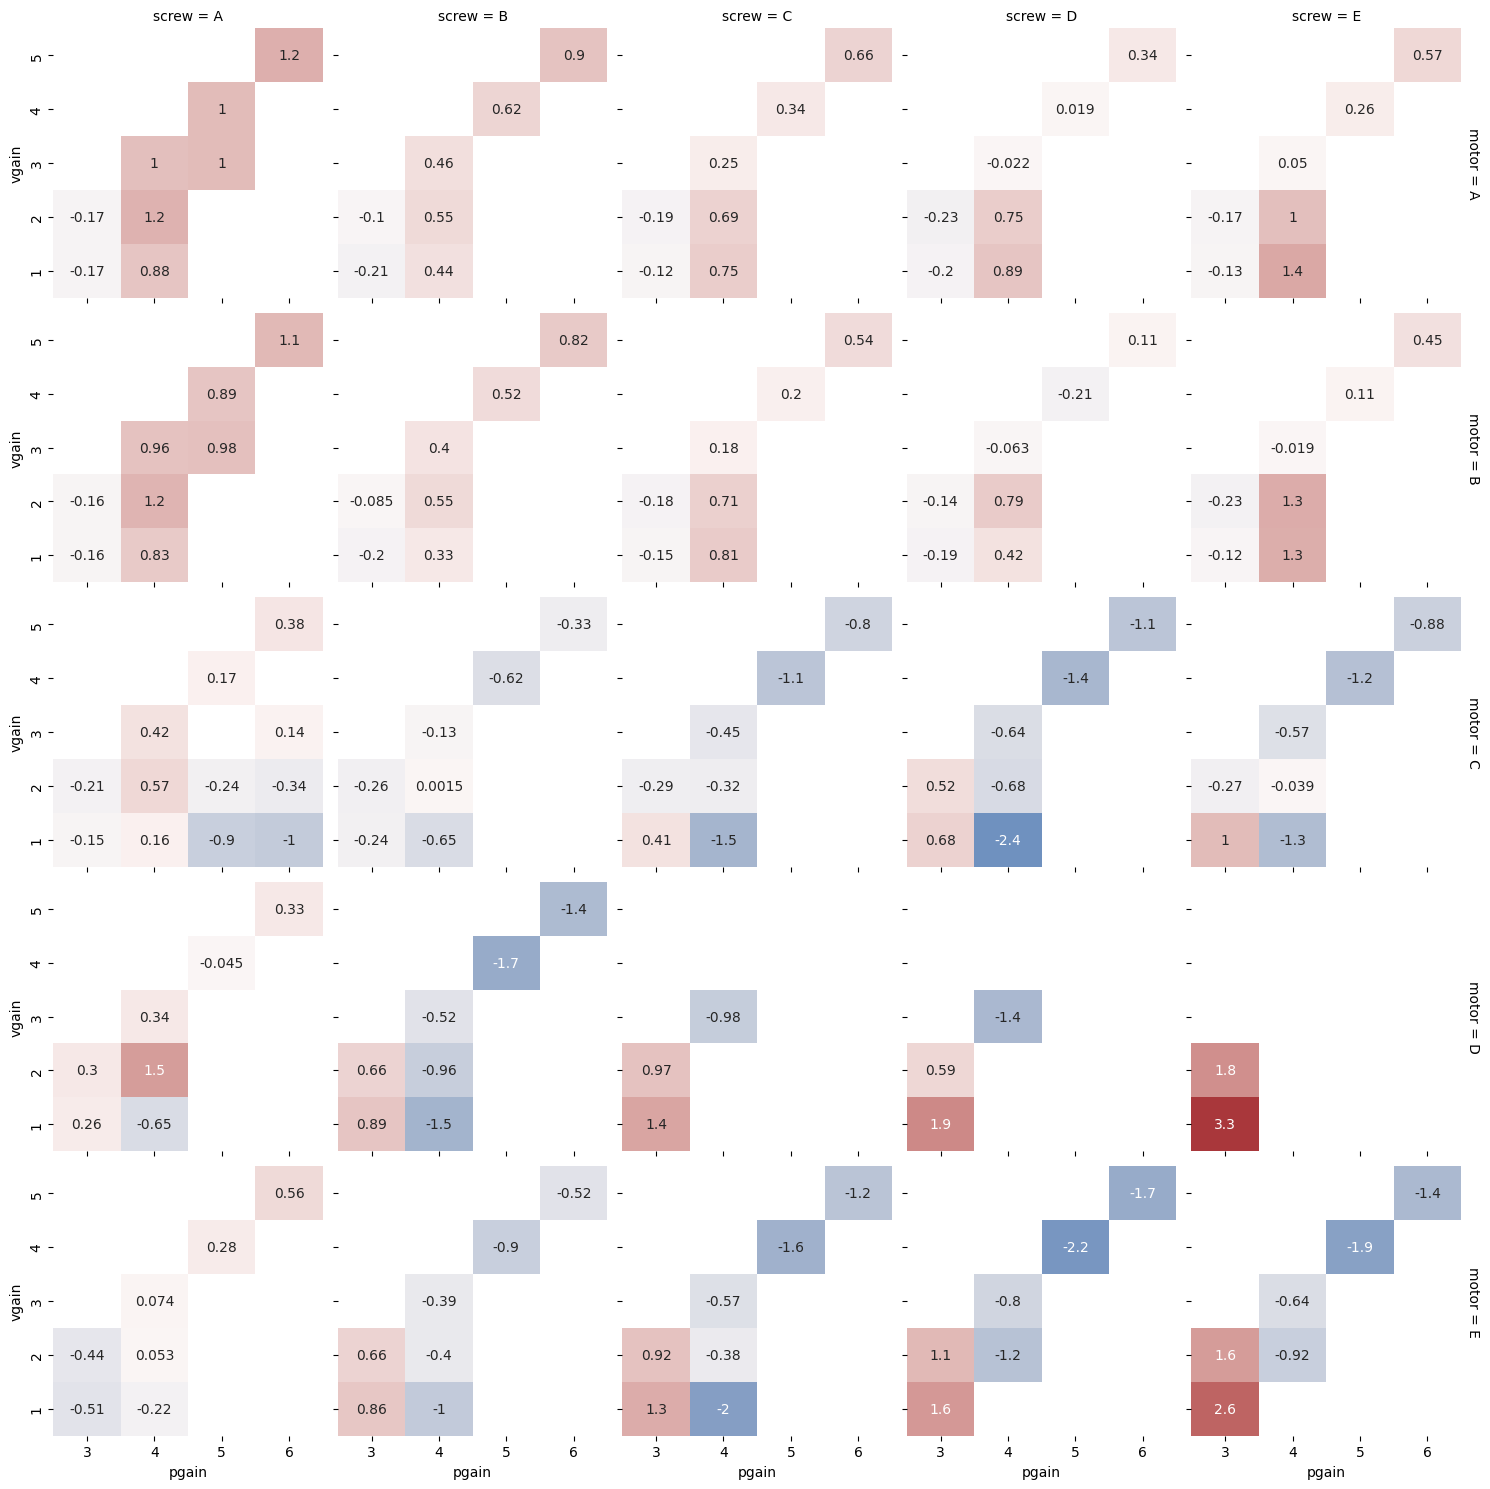

In [10]:
dataframeHeatmap(df_diff)

Визуализация и R2-Score показывают, что линейная модель не плохо подходит.

## Перцептрон

В учебных целях было решено использовать перцептрон не из sklearn.

In [85]:
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, input_dim, output_dim, num_layers=0, 
                 hidden_dim=64, p=0.0):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), 
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
        
        self.layers.add_module('classifier', 
                               torch.nn.Linear(prev_size, output_dim))        
        
    def forward(self, input):
        return self.layers(input)

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Базовые функции тестирования и обучения перцептрона

In [116]:
def testing(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=256)

    pred = []
    real = []
    for x, y in generator:
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)
        pred.extend(y_pred.cpu().detach().squeeze().numpy().tolist())
        real.extend(y.cpu().detach().numpy().tolist())

    return np.array(real), np.array(pred)

def trainer(model, dataset, loss_function, optimizer, epochs):
    for epoch in range(epochs):
        generator = torch.utils.data.DataLoader(dataset, batch_size=256,
                                              shuffle=True)
        for x, y in generator:
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)

            output = model(x).squeeze()
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

Функции-обертки

In [117]:
def evaluateAccuracy(model, dataset):
    model.to(device)
    _ = model.eval()
    y_real, y_pred = testing(model, dataset)
    score = r2_score(y_real, y_pred)
    print("Mean squared error: %.2f" % mean_squared_error(y_real, y_pred))
    print("Coefficient of determination: %.2f" % score)
    return score, y_real, y_pred

def trainCrossval(model_list, dataset, cross_val, epochs, lr):
    n_splits = cross_val.get_n_splits()
    assert n_splits == len(model_list)

    i = 0
    score_list = []
    X, y = dataset[:]

    for train_index, test_index in tqdm(cross_val.split(X), total=n_splits):
        x_train_fold = X[train_index]
        x_test_fold = X[test_index]
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]
    
        traindata = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
        testdata = torch.utils.data.TensorDataset(x_test_fold, y_test_fold)
    
        model = model_list[i]
        model.to(device)
        _ = model.train()
        trainer(model=model, 
                dataset=traindata, 
                loss_function=torch.nn.MSELoss(), 
                optimizer=torch.optim.Adam(model.parameters(), lr=lr), 
                epochs=epochs)
        
        _ = model.eval()
        _, y_pred_fold = testing(model, testdata)
        score = r2_score(y_test_fold, y_pred_fold)
        score_list.append(score)
        i += 1

    assert i == len(model_list) 
    return score_list

def optimizeHyperparameters(hp_grid, dataset, cross_val, epochs):
    hp_scores = []
    for hp in tqdm(hp_grid):
        model_list = [
            Perceptron(input_dim=len(features),
                       output_dim=1,
                       num_layers=hp['num_layers'],
                       hidden_dim=hp['hidden_dim'],
                       p=hp['p'])
            for i in range(cross_val.get_n_splits())
        ]

        score_list = trainCrossval(model_list, dataset, cross_val, epochs, lr=hp['lr'])
        hp_scores.append({
            'score' : np.mean(score_list),
            'hp' : hp
        })

    return sorted(hp_scores, key=lambda item: item['score'], reverse=True)

In [118]:
# Подготовка данных для pytorch
X = dffix[features].values
y = dffix[target].values
X = torch.Tensor(X)
y = torch.Tensor(y)
dset = TensorDataset(X, y)

### Наивная попытка

Попробуем значения _num_layers_ и _hidden_dim_ расположенные между _input_dim_ и _output_dim_

In [90]:
cv = KFold(4)
model_list = [Perceptron(num_layers=3, input_dim=len(features), output_dim=1, hidden_dim=4)
              for i in range(cv.get_n_splits())]
model_list[0]

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=6, out_features=4, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (layer1): Linear(in_features=4, out_features=4, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (layer2): Linear(in_features=4, out_features=4, bias=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [91]:
# Проверим точность до обучения.
for model in model_list:
    _ = evaluateAccuracy(model, dset)

Mean squared error: 4.39
Coefficient of determination: -0.82
Mean squared error: 5.04
Coefficient of determination: -1.08
Mean squared error: 3.28
Coefficient of determination: -0.36
Mean squared error: 4.52
Coefficient of determination: -0.87


In [92]:
# Обучим модели.
scores = trainCrossval(model_list, dset, cross_val=cv, epochs=1000, lr=0.001)
display(scores)
best = model_list[np.argmax(scores)]

  0%|          | 0/4 [00:00<?, ?it/s]

[0.9553474959618088,
 0.5769286044111852,
 0.8223073418978092,
 0.9029382781080415]

In [93]:
# Воспользуемся лучшей моделью из обученных.
score, y_real, y_pred = evaluateAccuracy(best, dset)

Mean squared error: 0.20
Coefficient of determination: 0.92


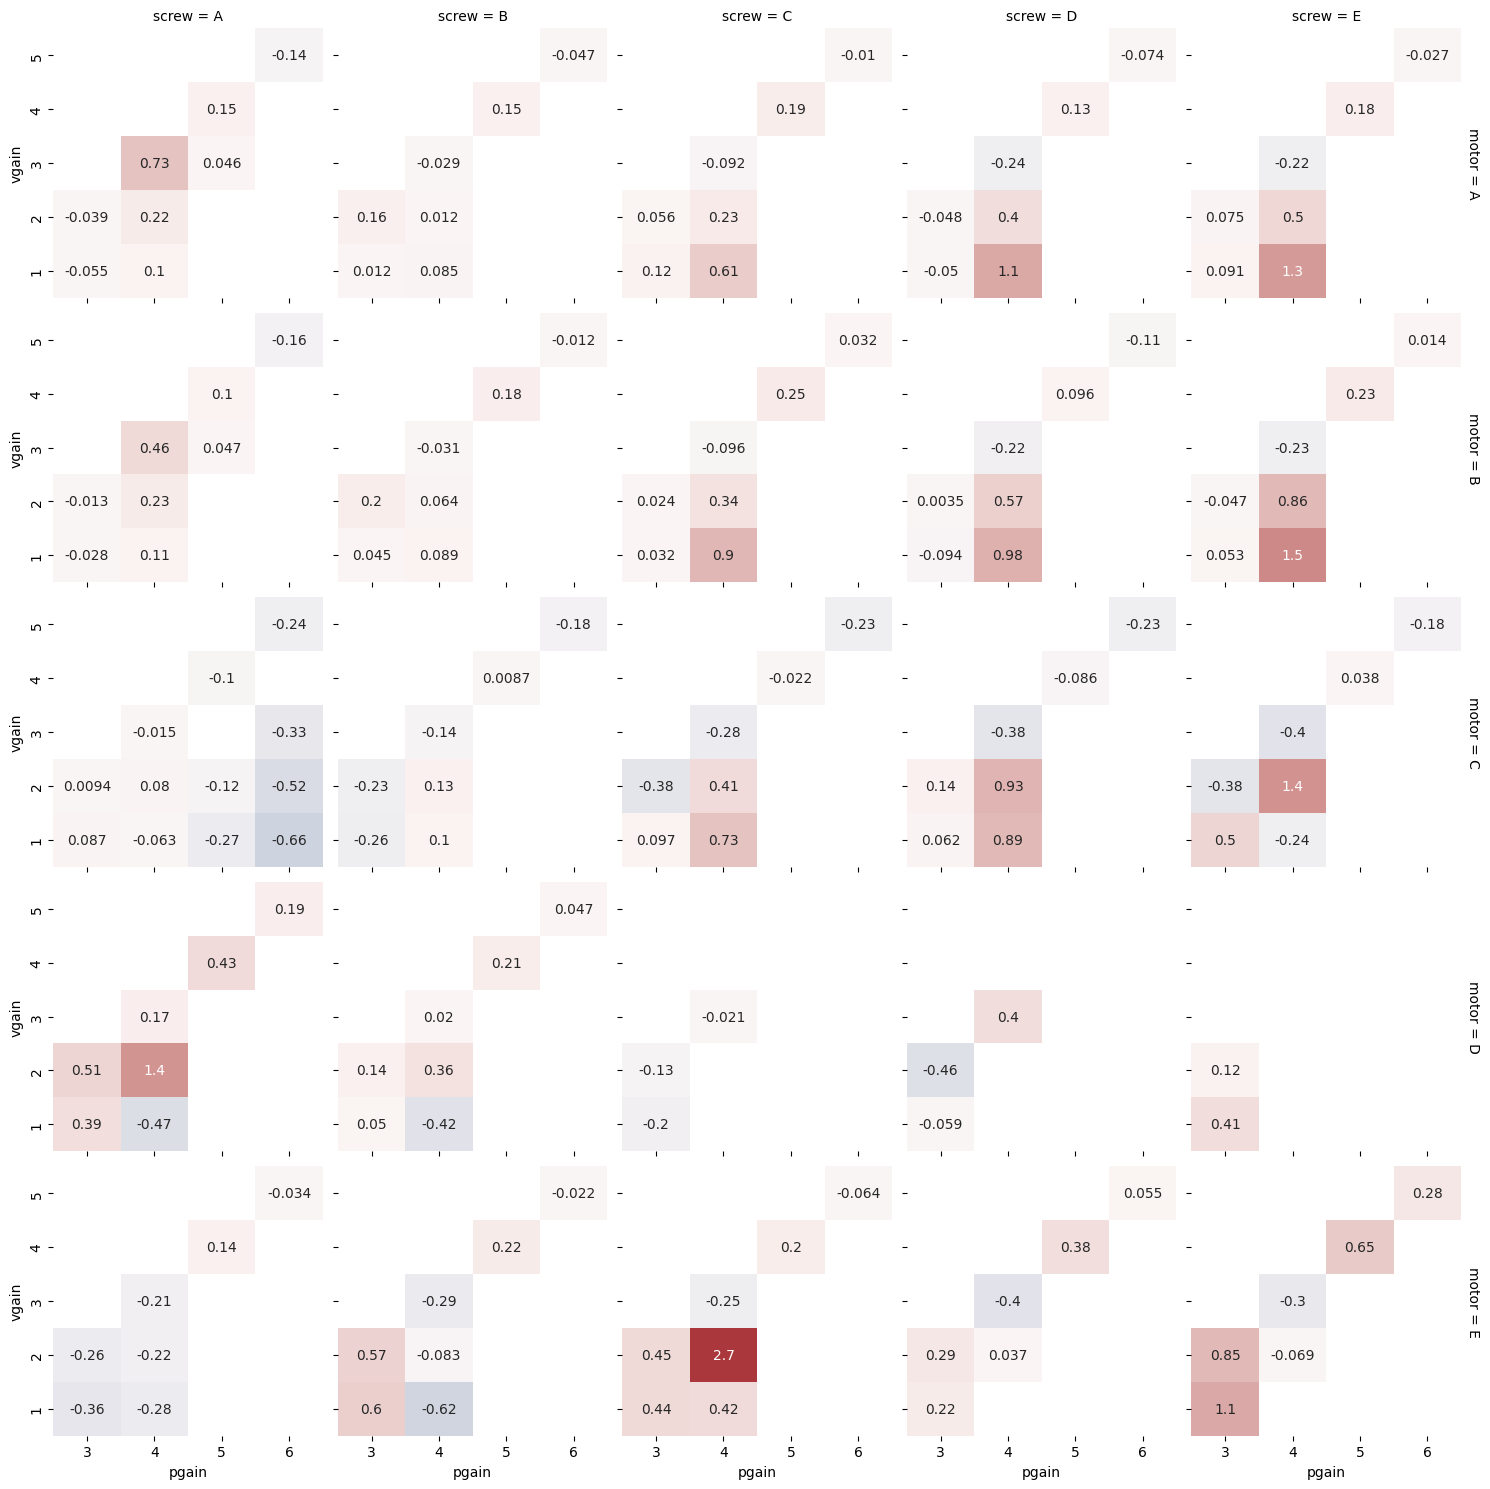

In [94]:
df_diff = df.copy()
df_diff[target] = (y_pred - y_real) / y_real

dataframeHeatmap(df_diff)

Перцептрон справляется с задачей лучше, чем линейная регрессия. Попробуем улучшить результат.

### Поиск лучшего перцептрона

Проведем подбор гиперпараметров.

In [95]:
cv = KFold(4)

hp_grid = ParameterGrid({'num_layers': [2, 3, 8], 
                         'hidden_dim': [4, 8, 16, 32],
                         'p': [0.0, 0.2],
                         'lr': [0.001]})


Оптимизация по гиперпараметрам -- весьма продолжительная операция.

In [96]:
scores = optimizeHyperparameters(hp_grid, dset, cv, 1000)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [53]:
for entry in scores:
    print(f"{entry['score']:.3f}: {entry['hp']}")

0.895: {'hidden_dim': 32, 'lr': 0.001, 'num_layers': 8, 'p': 0.2}
0.894: {'hidden_dim': 32, 'lr': 0.001, 'num_layers': 8, 'p': 0.0}
0.882: {'hidden_dim': 16, 'lr': 0.001, 'num_layers': 8, 'p': 0.0}
0.881: {'hidden_dim': 32, 'lr': 0.001, 'num_layers': 3, 'p': 0.0}
0.877: {'hidden_dim': 32, 'lr': 0.001, 'num_layers': 3, 'p': 0.2}
0.867: {'hidden_dim': 16, 'lr': 0.001, 'num_layers': 3, 'p': 0.2}
0.866: {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 3, 'p': 0.0}
0.864: {'hidden_dim': 16, 'lr': 0.001, 'num_layers': 2, 'p': 0.2}
0.861: {'hidden_dim': 16, 'lr': 0.001, 'num_layers': 3, 'p': 0.0}
0.861: {'hidden_dim': 4, 'lr': 0.001, 'num_layers': 3, 'p': 0.0}
0.859: {'hidden_dim': 32, 'lr': 0.001, 'num_layers': 2, 'p': 0.2}
0.858: {'hidden_dim': 32, 'lr': 0.001, 'num_layers': 2, 'p': 0.0}
0.855: {'hidden_dim': 16, 'lr': 0.001, 'num_layers': 8, 'p': 0.2}
0.853: {'hidden_dim': 16, 'lr': 0.001, 'num_layers': 2, 'p': 0.0}
0.793: {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 3, 'p': 0.2}
0.774: {'hidd

### Обучение лучшего перцептрона

По результатам оптимизации выберем лучший набор гиперпараметров.

In [97]:
# Создание перцептрона
num_layers=8
hidden_dim=32
p=0.2
lr=0.001
cv = KFold(4)

model_list = [
    Perceptron(num_layers=num_layers, hidden_dim=hidden_dim, p=p,
               input_dim=len(features), output_dim=1)
    for i in range(cv.get_n_splits())
]

Обучим перцептрон. При обучении используется итеративный метод **Adam**, поэтому количество итераций можно увеличивать, пока точность не перестанет улучшаться.

In [104]:
# Данную ячейку можно перезапускать для кумулятивного увеличения количества итераций оптимизатора

# Точность до этапа обучения
for m in model_list:
    evaluateAccuracy(m, dset)

# Обучение модели
scores = trainCrossval(model_list, dset, cv, 1000, lr)
print(scores)

# Точность после обучения
for m in model_list:
    evaluateAccuracy(m, dset)


Mean squared error: 0.15
Coefficient of determination: 0.94
Mean squared error: 0.15
Coefficient of determination: 0.94
Mean squared error: 0.08
Coefficient of determination: 0.96
Mean squared error: 0.10
Coefficient of determination: 0.96


  0%|          | 0/4 [00:00<?, ?it/s]

[0.8606672554767205, 0.71894342394488, 0.8595044573946438, 0.9220588776195705]
Mean squared error: 0.14
Coefficient of determination: 0.94
Mean squared error: 0.26
Coefficient of determination: 0.89
Mean squared error: 0.07
Coefficient of determination: 0.97
Mean squared error: 0.11
Coefficient of determination: 0.96


In [119]:
# Выбор лучшей модели по результатам на тестовой выборке
best = model_list[np.argmax(scores)]
score, y_real, y_pred = evaluateAccuracy(best, dset)

Mean squared error: 0.11
Coefficient of determination: 0.96


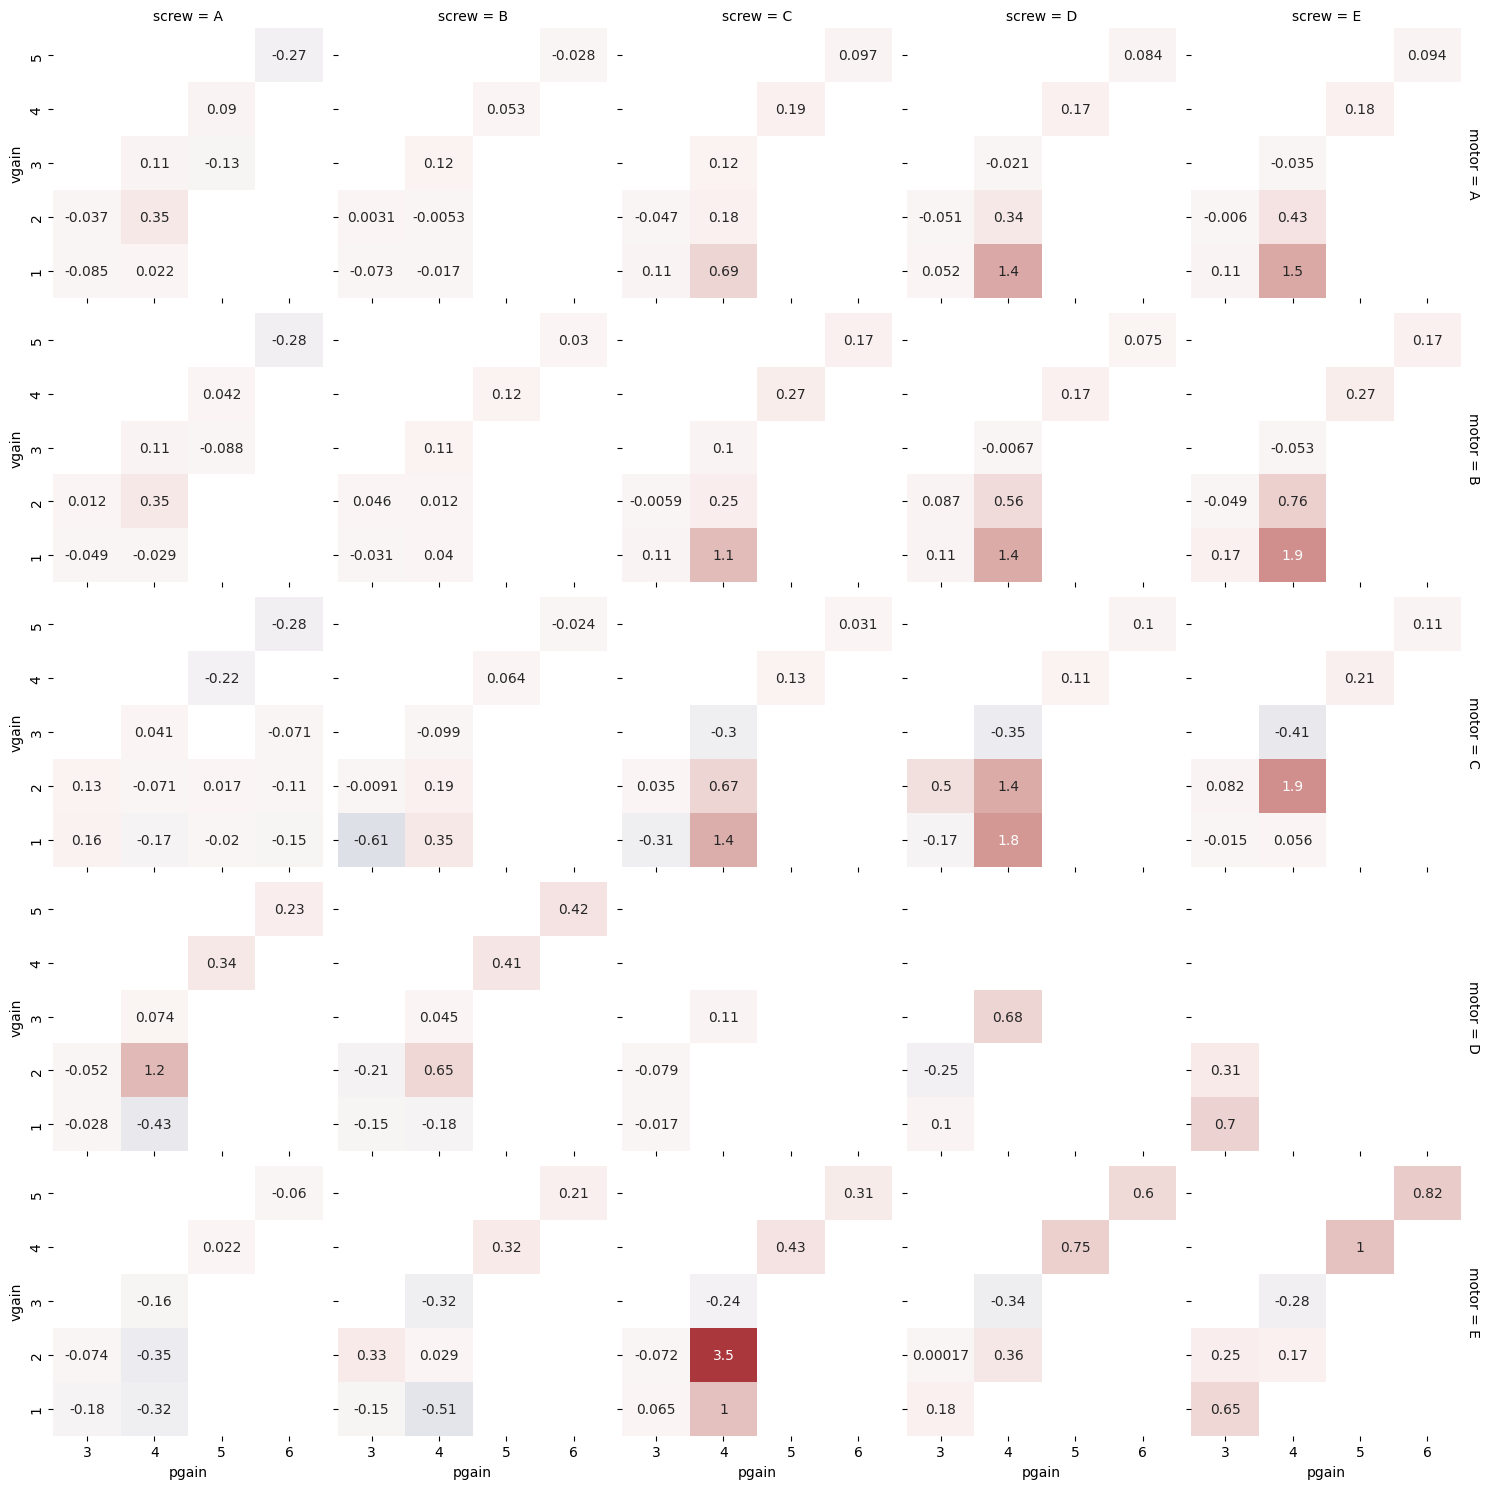

In [107]:
# Визуализация относительной ошибки на всей выборке
df_diff = df.copy()
df_diff[target] = (y_pred - y_real) / y_real

dataframeHeatmap(df_diff)

Оптимизация гиперпараметров и обучение перцептрона дало результат в R2-Score = 0.96 на всей выборке.
Однако обучение перцептрона -- гораздо более затратная операция, чем линейная регрессия.

С помощью dropout мы боремся с переобучением, которое может возникать из-за большого числа параметров модели.

Мы также можем заметить, что в выборке есть значительные выбросы.

## SVR

Воспользуемся методом опорных векторов для регрессии (Support Vector Regression).

In [120]:
from sklearn.svm import SVR

In [121]:
X = dffix[features].values
y = dffix[target].values

In [122]:
def evaluateAccuracy(model, X, y_real):
    y_pred = model.predict(X)
    score = r2_score(y_real, y_pred)
    print("Mean squared error: %.2f" % mean_squared_error(y_real, y_pred))
    print("Coefficient of determination: %.2f" % score)
    return score, y_real, y_pred

def trainCrossval(model_list, X, y, cross_val):
    n_splits = cross_val.get_n_splits()
    assert n_splits == len(model_list)

    i = 0
    score_list = []

    for train_index, test_index in tqdm(cross_val.split(X), total=n_splits):
        x_train_fold = X[train_index]
        x_test_fold = X[test_index]
        y_train_fold = y[train_index]
        y_test_fold = y[test_index]
    
        model = model_list[i]
        _ = model.fit(x_train_fold, y_train_fold)

        y_pred_fold = model.predict(x_test_fold)
        score = r2_score(y_test_fold, y_pred_fold)
        score_list.append(score)
        i += 1

    assert i == len(model_list) 
    return score_list

def optimizeHyperparameters(hp_grid, X, y, cross_val):
    hp_scores = []
    for hp in tqdm(hp_grid):
        model_list = [
            SVR(kernel=hp['kernel'],
                C=hp['C'],
                epsilon=hp['epsilon'])
            for i in range(cross_val.get_n_splits())
        ]

        print(hp)
        score_list = trainCrossval(model_list, X, y, cross_val)
        hp_scores.append({
            'score' : np.mean(score_list),
            'hp' : hp
        })

    return sorted(hp_scores, key=lambda item: item['score'], reverse=True)

In [75]:
cv = KFold(4)
hp_grid = ParameterGrid({'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'C': [1e-3, 1e-1, 1e1, 1e3],
                         'epsilon': [1e-3, 1e-1, 1e1, 1e3]})
    
scores = optimizeHyperparameters(hp_grid, X, y, cv)
for entry in scores:
    print(f"{entry['score']:.3f}: {entry['hp']}")

  0%|          | 0/64 [00:00<?, ?it/s]

{'C': 0.001, 'epsilon': 0.001, 'kernel': 'linear'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.001, 'epsilon': 0.001, 'kernel': 'poly'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.001, 'epsilon': 0.001, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.001, 'epsilon': 0.001, 'kernel': 'sigmoid'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.001, 'epsilon': 0.1, 'kernel': 'linear'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.001, 'epsilon': 0.1, 'kernel': 'poly'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.001, 'epsilon': 0.1, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.001, 'epsilon': 0.1, 'kernel': 'sigmoid'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.001, 'epsilon': 10.0, 'kernel': 'linear'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.001, 'epsilon': 10.0, 'kernel': 'poly'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.001, 'epsilon': 10.0, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.001, 'epsilon': 10.0, 'kernel': 'sigmoid'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.001, 'epsilon': 1000.0, 'kernel': 'linear'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.001, 'epsilon': 1000.0, 'kernel': 'poly'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.001, 'epsilon': 1000.0, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.001, 'epsilon': 1000.0, 'kernel': 'sigmoid'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.1, 'epsilon': 0.001, 'kernel': 'linear'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.1, 'epsilon': 0.001, 'kernel': 'poly'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.1, 'epsilon': 0.001, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.1, 'epsilon': 0.001, 'kernel': 'sigmoid'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.1, 'epsilon': 0.1, 'kernel': 'poly'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.1, 'epsilon': 0.1, 'kernel': 'sigmoid'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.1, 'epsilon': 10.0, 'kernel': 'linear'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.1, 'epsilon': 10.0, 'kernel': 'poly'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.1, 'epsilon': 10.0, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.1, 'epsilon': 10.0, 'kernel': 'sigmoid'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.1, 'epsilon': 1000.0, 'kernel': 'linear'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.1, 'epsilon': 1000.0, 'kernel': 'poly'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.1, 'epsilon': 1000.0, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 0.1, 'epsilon': 1000.0, 'kernel': 'sigmoid'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10.0, 'epsilon': 0.001, 'kernel': 'linear'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10.0, 'epsilon': 0.001, 'kernel': 'poly'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10.0, 'epsilon': 0.001, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10.0, 'epsilon': 0.001, 'kernel': 'sigmoid'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10.0, 'epsilon': 0.1, 'kernel': 'linear'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10.0, 'epsilon': 0.1, 'kernel': 'poly'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10.0, 'epsilon': 0.1, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10.0, 'epsilon': 0.1, 'kernel': 'sigmoid'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10.0, 'epsilon': 10.0, 'kernel': 'linear'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10.0, 'epsilon': 10.0, 'kernel': 'poly'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10.0, 'epsilon': 10.0, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10.0, 'epsilon': 10.0, 'kernel': 'sigmoid'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10.0, 'epsilon': 1000.0, 'kernel': 'linear'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10.0, 'epsilon': 1000.0, 'kernel': 'poly'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10.0, 'epsilon': 1000.0, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10.0, 'epsilon': 1000.0, 'kernel': 'sigmoid'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 0.001, 'kernel': 'linear'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 0.001, 'kernel': 'poly'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 0.001, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 0.001, 'kernel': 'sigmoid'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 0.1, 'kernel': 'linear'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 0.1, 'kernel': 'poly'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 0.1, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 0.1, 'kernel': 'sigmoid'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 10.0, 'kernel': 'linear'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 10.0, 'kernel': 'poly'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 10.0, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 10.0, 'kernel': 'sigmoid'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 1000.0, 'kernel': 'linear'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 1000.0, 'kernel': 'poly'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 1000.0, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 1000.0, 'kernel': 'sigmoid'}


  0%|          | 0/4 [00:00<?, ?it/s]

0.891: {'C': 1000.0, 'epsilon': 0.001, 'kernel': 'rbf'}
0.890: {'C': 1000.0, 'epsilon': 0.1, 'kernel': 'rbf'}
0.777: {'C': 1000.0, 'epsilon': 0.001, 'kernel': 'poly'}
0.770: {'C': 1000.0, 'epsilon': 0.1, 'kernel': 'poly'}
0.735: {'C': 10.0, 'epsilon': 0.1, 'kernel': 'rbf'}
0.710: {'C': 10.0, 'epsilon': 0.001, 'kernel': 'rbf'}
0.581: {'C': 1000.0, 'epsilon': 0.1, 'kernel': 'linear'}
0.566: {'C': 1000.0, 'epsilon': 0.001, 'kernel': 'linear'}
0.372: {'C': 10.0, 'epsilon': 0.1, 'kernel': 'linear'}
0.362: {'C': 10.0, 'epsilon': 0.001, 'kernel': 'linear'}
0.278: {'C': 10.0, 'epsilon': 0.1, 'kernel': 'poly'}
0.271: {'C': 10.0, 'epsilon': 0.001, 'kernel': 'poly'}
0.156: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
0.143: {'C': 0.1, 'epsilon': 0.001, 'kernel': 'linear'}
0.094: {'C': 0.1, 'epsilon': 0.001, 'kernel': 'rbf'}
0.087: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}
0.032: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'poly'}
0.019: {'C': 0.1, 'epsilon': 0.001, 'kernel': 'poly'}
-0.083: {'C': 0.

Уменьшим диапазон гиперпараметров для нахождения наиболее подходящих.

In [77]:
cv = KFold(4)
hp_grid = ParameterGrid({'kernel': ['rbf'],
                         'C': [1e3, 1e4],
                         'epsilon': [1e-3, 1e-2, 1e-1]})
    
scores = optimizeHyperparameters(hp_grid, X, y, cv)
for entry in scores:
    print(f"{entry['score']:.3f}: {entry['hp']}")

  0%|          | 0/6 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 0.001, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 0.01, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 1000.0, 'epsilon': 0.1, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10000.0, 'epsilon': 0.001, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10000.0, 'epsilon': 0.01, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

{'C': 10000.0, 'epsilon': 0.1, 'kernel': 'rbf'}


  0%|          | 0/4 [00:00<?, ?it/s]

0.891: {'C': 1000.0, 'epsilon': 0.01, 'kernel': 'rbf'}
0.891: {'C': 1000.0, 'epsilon': 0.001, 'kernel': 'rbf'}
0.890: {'C': 1000.0, 'epsilon': 0.1, 'kernel': 'rbf'}
0.873: {'C': 10000.0, 'epsilon': 0.001, 'kernel': 'rbf'}
0.873: {'C': 10000.0, 'epsilon': 0.01, 'kernel': 'rbf'}
0.862: {'C': 10000.0, 'epsilon': 0.1, 'kernel': 'rbf'}


Воспользуемся наилучшим набором гиперпараметров

In [126]:
cv = KFold(4)
model_list = [
    SVR(kernel='rbf',
        C=1000,
        epsilon=0.01,
        tol=1e-7)
    for i in range(cv.get_n_splits())
]

scores = trainCrossval(model_list, X, y, cv)
print(scores)

for m in model_list:
    _ = evaluateAccuracy(m, X, y)

  0%|          | 0/4 [00:00<?, ?it/s]

[0.9469803232005695, 0.7375939669808949, 0.9511021865856999, 0.9301521718969984]
Mean squared error: 0.25
Coefficient of determination: 0.90
Mean squared error: 0.28
Coefficient of determination: 0.88
Mean squared error: 0.27
Coefficient of determination: 0.89
Mean squared error: 0.23
Coefficient of determination: 0.91


In [127]:
# Выбор лучшей модели
best = model_list[np.argmax(scores)]
score, y_real, y_pred = evaluateAccuracy(best, X, y)

Mean squared error: 0.27
Coefficient of determination: 0.89


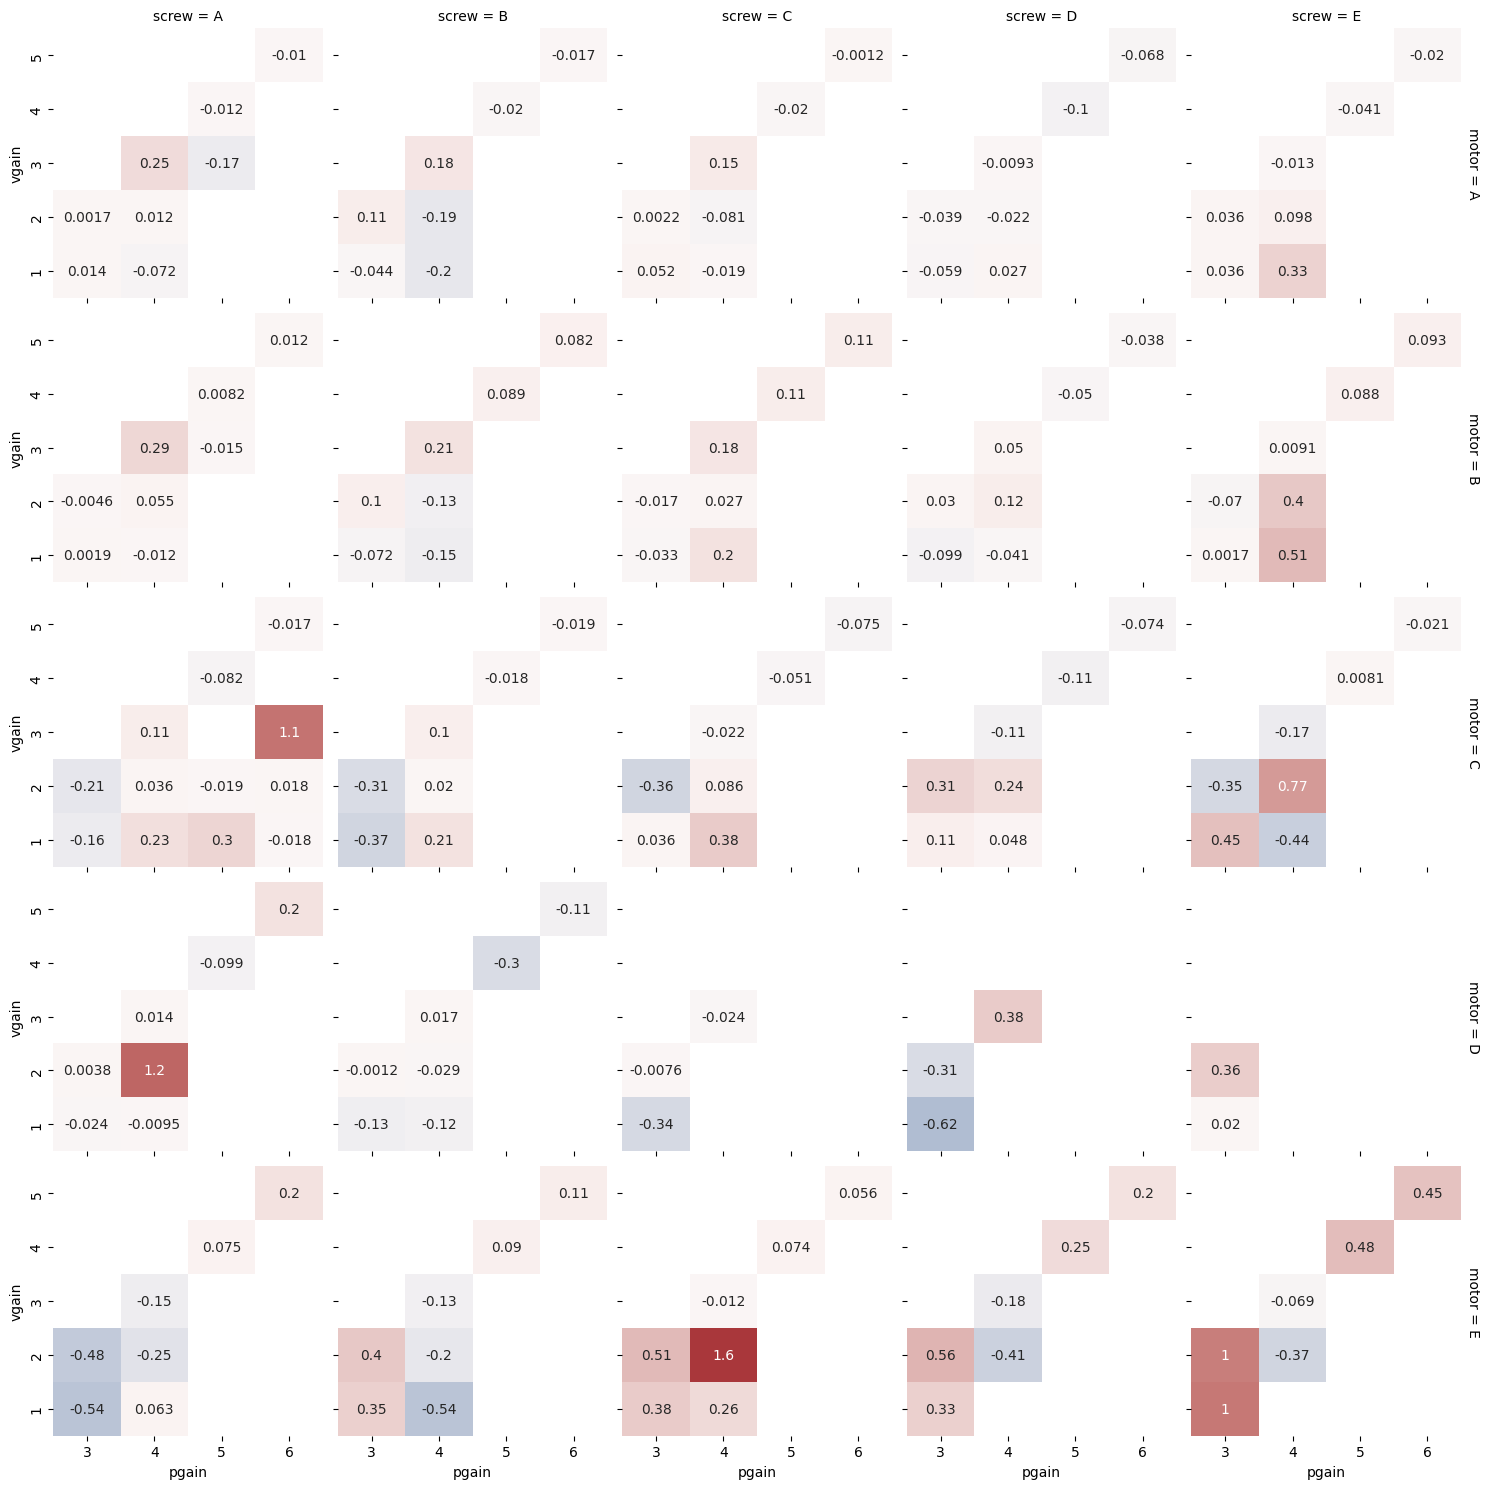

In [128]:
# Визуализация относительной ошибки на всей выборке
df_diff = df.copy()
df_diff[target] = (y_pred - y_real) / y_real

dataframeHeatmap(df_diff)

# Анализ полученных результатов

В результате предварительного анализа датасета удалось:
- Получить метод визуализации.
- Преобразовать категориальные признаки.
- Добавить несколько признаков, имеющих за собой теоретическое обоснование.

После обучения и проверки моделей на изучаемом датасете были получены следующие выводы.

Линейная модель:
- Не является состоятельной моделью даже при условии добавления экспоненциальных признаков.

Перцептрон:
- Позволяет получить хорошую модель, однако требует много ресурсов для обучения.
- Имеет множество параметров, что повышает шансы на переобучение.

SVR:
- SVR не требует много ресурсов для обучения.
- Не дает такой высокой точности, как перцептрон, однако лучше линейной регрессии.


| Модель   | Линейная регрессия | Перцептрон | SVR  |
|----------|--------------------|------------|------|
| R2-Score |  0.74              | 0.96       | 0.89 |

### Проблемы и трудности:

- Описание dataset-a малоинформативно относительно приводимых признаков. Это затрудняет предварительный анализ и визуализацию.
- Написанный вручную перцептрон медленно обучается вледствие неопытности в написании кода на pytorch.
- Требуется более подробный анализ на переобучение перцептрона. Возможно, количество и размеры слоев слишком велики.